In [1]:
import os 
import sys
import random
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import lognorm
from scipy.stats import norm 
from scipy import integrate
from scipy.stats import gmean

from scipy.stats import pearsonr

import statsmodels.api as sm 
import statsmodels.formula.api as smf

### src; https://github.com/arkottke/pyrotd
import pyrotd



/Users/laxmandahal/opt/miniconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
8%2

0

In [3]:
with open('BuildingNames.txt', 'r') as f:
    BuildingList = f.read() 
BuildingList = BuildingList.split('\n')
BuildingList

['s1_48x32_high',
 's1_48x32_veryhigh',
 's1_96x48_high',
 's1_96x48_veryhigh',
 's2_48x32_high',
 's2_48x32_veryhigh',
 's2_96x48_high',
 's2_96x48_veryhigh',
 's4_96x48_high',
 's4_96x48_veryhigh']

In [4]:
baseDir = r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study'

## time period of the buildings
# T = np.array([0.13, 0.12, 0.22, 0.22, 0.16, 0.15, 0.26, 0.25, 0.49, 0.49])
T = np.array([0.13, 0.12, 0.16, 0.15, 0.22, 0.22, 0.26, 0.25, 0.49, 0.49])

numGM = 826
g = 980.665 ## converts GM record to cm/sec^2

def compute_RotDxx_EDP(edpX, edpZ, percentile = 50):
    angles = np.arange(0, 180, step=1)
    radians = np.radians(angles)
    coeffs = np.c_[np.cos(radians), np.sin(radians)]
    
    edp_stacked = np.vstack([edpX, edpZ])
    rotated_edp = np.dot(coeffs, edp_stacked)
    percentile_edp = np.percentile(rotated_edp, q = percentile, axis = 0, interpolation='linear')
    return percentile_edp

In [5]:
# heresi_GM_dir = os.path.join(baseDir, *['References', 'Heresi GMs'])
# os.chdir(heresi_GM_dir)
# heresiGM = pd.read_csv('Ground Motion Records.csv')
# RSNs = heresiGM['Record Sequence Number\n(NGA-West2)'].values
# np.savetxt('Heresi_831_RSNs.txt',[RSNs], delimiter=',', fmt='%d')

In [6]:
gminfo_h1 = pd.read_csv(r'data/Complete_GM_info_h1.csv')
gminfo_h1 = gminfo_h1.set_index('key_0')
gminfo_h1.index.names = ['GMID']

In [7]:
gminfo_h2 = pd.read_csv(r'data/Complete_GM_info_h2.csv')
gminfo_h2 = gminfo_h2.set_index('key_0')
gminfo_h2.index.names = ['GMID']

In [8]:
gminfo_rotD50 = pd.read_csv(r'data/Complete_GM_info_RotD50.csv')
gminfo_rotD50 = gminfo_rotD50.set_index('key_0')
gminfo_rotD50.index.names = ['GMID']
gminfo_rotD50.columns

Index(['PGA', 'PGV', 'DS_5to75', 'DS_5to95', 'CAV', 'T_0.01', 'T_0.02',
       'T_0.03', 'T_0.04', 'T_0.05',
       ...
       'SI', 'ASI', 'DSI', 'Sa_avg', '5-75% Duration (sec)_NGA2',
       '5-95% Duration (sec)_NGA2', 'Magnitude', 'Distance_Rjb',
       'Distance_rup', 'Vs_30'],
      dtype='object', length=156)

In [9]:
sv_rotD50 = pd.read_csv('data/Spectral_velocity_rotD50.csv', index_col='GMID')
sd_rotD50 = pd.read_csv('data/Spectral_Displacement_rotD50.csv', index_col='GMID')

In [10]:
# os.chdir(os.path.join(baseDir, *['Codes', 'data']))
# np.savetxt('Magnitude.txt', gminfo_rotD50['Magnitude'].values, fmt = '%.3f')
# np.savetxt('Distance_Rjb.txt', gminfo_rotD50['Distance_Rjb'].values, fmt = '%.3f')

## Defining Classes for efficiency and sufficiency

In [11]:
class OLS:
    def __init__(self, EDP, IM):
        self.EDP = EDP
        self.IM = IM
        self.Y = np.log(EDP)
        self.X = sm.add_constant(np.log(IM))
        
        self.residual_mean = None
        self.residual_std = None
        self.xmin = None
        self.xmax = None
        
        self.fitModel()
        self.get_summary()
        
#         self.plot_residuals_hist()
#         self.plot_model_fit()
        
    def fitModel(self):
        model = sm.OLS(self.Y, self.X)
        self.result = model.fit()
        
    def get_summary(self):
        return self.result.summary()
    
    def plot_residuals_hist(self):
        fig, ax = plt.subplots()
        sns.histplot(x = self.result.resid, ax=ax, stat = 'density', linewidth = 0, kde=True)
        ax.set(title = 'Distribution of residuals', xlabel = 'residuals')
        
        self.residual_mean, self.residual_std = norm.fit(self.result.resid)
        ##plotting normal pdf
        self.xmin, self.xmax = plt.xlim() # using maxi/min values from histogram
        x = np.linspace(self.xmin, self.xmax, 200)
        pdf = norm.pdf(x, self.residual_mean, self.residual_std)
        sns.lineplot(x = x, y = pdf, color = 'red', ax = ax)
        plt.show()
    
    def get_efficiency(self):
        return np.std(self.result.resid)
            
    def qqplot(self):
        sm.qqplot(self.result.resid, line = 's')


    def fitplot(self):
        sm.graphics.plot_fit(self.result, 1, vlines = False);
        
    def plot_model_fit(self):
        Ymin = self.Y.min()
        Ymax = self.Y.max()
#         ax = sns.subplots()
        ax = sns.scatterplot(x = self.result.fittedvalues, y = self.Y)
#         ax.set_ylim(Ymin, Ymax)
#         ax.set_xlim(self.xmin, self.xmax)
        ax.set_xlabel('Predicted Values')
        ax.set_ylabel('Observed Values')
        
        X_ref = Y_ref = np.linspace(Ymin, Ymax, 200)
        plt.plot(X_ref, Y_ref, color = 'red', linewidth = 1.3)
        plt.show()
        
class Sufficiency():
    def __init__(self, ln_EDP, ln_IM, Rjb, Mag):
        self.EDP = ln_EDP
        self.IM = ln_IM
        self.X = sm.add_constant(self.IM)
        
        temp = {'I': np.ones(shape = len(Mag)),
                'lnEDP': self.EDP,
                'lnIM': self.IM,
                'lnRjb': np.log(Rjb),
                'M': Mag}
        self.dummydf = pd.DataFrame(temp, index = None)
        
        self.sufficiency_against_R()
        self.sufficiency_against_M()
        self.sufficiency_against_M_and_R()
        
    def sufficiency_against_R(self):
        self.model_IM_vs_R = smf.ols('lnEDP ~ lnIM + lnRjb', data = self.dummydf)
        model_res = self.model_IM_vs_R.fit()
        self.summary_against_R = model_res.summary()
        return model_res.pvalues['lnRjb']
        
    def sufficiency_against_M(self):
        self.model_IM_vs_M = smf.ols('lnEDP ~ lnIM + M', data = self.dummydf)
        model_res = self.model_IM_vs_M.fit()
        self.summary_against_M = model_res.summary()
        return model_res.pvalues['M']

    def sufficiency_against_M_and_R(self):
        self.model_IM_vs_R_and_M = smf.ols('lnEDP ~ lnIM + M + lnRjb', data = self.dummydf)
        model_res = self.model_IM_vs_R_and_M.fit()
        self.summary_against_M_and_R = model_res.summary()
        return model_res.pvalues
    
    def qqplot(self, model):
        sm.qqplot(model.fit(), line = 's')
      

In [12]:
def SummaryResutls_efficiency(buildingIndex, df_IMs, IMs=['SaT1', 'PGA', 'PGV', 'Sa_avg'],
                              pairingID = 1, average_EDP = False, rotate_EDP = False):
    '''
    pairingID: if 1, GM_h1 applied in X-direction, GM_h2 applied in Y-direction
               if 2, GM_h2 applied in X-direction, GM_h1 applied in Y-direction
               
    Note:
    Care must be taken while using gminfo and pairing ID
    -------------
    df_IMs = gminfo_RotD50 can be used with pairing ID 1 OR 2 
    df_IMs = gminfo_h1 can only be used with pairing ID 1
    df_IMs = gminfo_h2 can only be used with pairing ID 2
    '''
    dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])
    os.chdir(dataDir)
    sdr = pd.read_csv('SDR.csv', header = None)
    pfa = pd.read_csv('PFA.csv', header = None)
    
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
    tempdf = []
    d = []
    keys = ['1st Story', '2nd Story', '3rd Story', '4th Story']
    temp_sdr = {}
    
    if pairingID == 1:
        start_index_multiplier = 0
        end_index_multiplier = 1
    else:
        start_index_multiplier = 2
        end_index_multiplier = 3
    
    for i in range(len(IMs)):
        if IMs[i] == 'SaT1':
            IM = df_IMs['T_%s'%T[buildingIndex]].values
            ######### result for SaT1, SvT1 and SdT1 is the same b/c they are constantly relate
#         elif IMs[i] == 'SvT1':
#             IM = sv_rotD50['T_%s'%T[buildingIndex]].values
#         elif IMs[i] == 'SdT1':
#             IM = sd_rotD50['T_%s'%T[buildingIndex]].values
        else:
            IM = df_IMs[IMs[i]]

        for j in range(numStory):
            
            sdrX = sdr[3+j].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
            sdrZ = sdr[3+j].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

            pfaX = pfa[4+j].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
            pfaZ = pfa[4+j].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]
            
            if average_EDP:
                sdrX_avg = gmean([sdr[3+j].values[0:numGM], sdr[3+j].values[numGM*2:numGM*3]])
                pfaX_avg = gmean([pfa[4+j].values[0:numGM], pfa[4+j].values[numGM*2:numGM*3]])
                
                sdrZ_avg = gmean([sdr[3+j].values[numGM:numGM*2], sdr[3+j].values[numGM*3:numGM*4]])
                pfaZ_avg = gmean([pfa[4+j].values[numGM:numGM*2], pfa[4+j].values[numGM*3:numGM*4]])
#                 compute_RotDxx_EDP(sdrX, sdrZ, percentile=50)
#                 pfa_rotD50 = compute_RotDxx_EDP(pfaX, pfaZ, percentile=50)
                if rotate_EDP:
                    sdr_rotD50 = compute_RotDxx_EDP(sdrX_avg, sdrZ_avg, percentile=50)
                    pfa_rotD50 = compute_RotDxx_EDP(pfaX_avg, pfaZ_avg, percentile=50)
                    ols_sdrX = OLS(sdr_rotD50, IM)
                    ols_pfaZ = OLS(pfa_rotD50, IM)
                    temp_sdr[keys[j]] = {'SDR_RotD50':ols_sdrX.get_efficiency(),
                                         'PFA_RotD50': ols_pfaZ.get_efficiency()}
                else:
                    ols_sdrX = OLS(sdrX_avg, IM)
                    ols_sdrZ = OLS(sdrZ_avg, IM)
                    ols_pfaX = OLS(pfaX_avg, IM)
                    ols_pfaZ = OLS(pfaZ_avg, IM)
                    temp_sdr[keys[j]] = {'SDR_X_Avg':ols_sdrX.get_efficiency(),
                                         'SDR_Z_Avg':ols_sdrZ.get_efficiency(),
                                         'PFA_X_Avg': ols_pfaX.get_efficiency(),
                                         'PFA_Z_Avg': ols_pfaZ.get_efficiency()}
            else:
                ols_sdrX = OLS(sdrX, IM)
                ols_sdrZ = OLS(sdrZ, IM)
                ols_pfaX = OLS(pfaX, IM)
                ols_pfaZ = OLS(pfaZ, IM)
                temp_sdr[keys[j]] = {'SDR_X':ols_sdrX.get_efficiency(),
                                     'SDR_Z':ols_sdrZ.get_efficiency(),
                                     'PFA_X': ols_pfaX.get_efficiency(),
                                     'PFA_Z': ols_pfaZ.get_efficiency()}
        reform = {(outerKey, innerKey): values for outerKey, innerDict in temp_sdr.items() for innerKey, values in innerDict.items()}
        df = pd.DataFrame.from_dict(reform, orient='index').transpose()
        df.columns = pd.MultiIndex.from_tuples(df.columns)
        df['IM'] = IMs[i]
        df = df.set_index('IM')
        tempdf.append(df)

    return pd.concat(tempdf)


In [14]:
IM_list = ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI','DS_5to75', 'DS_5to95' ]
s1_48x32_high= SummaryResutls_efficiency(9, gminfo_rotD50, IM_list, pairingID = 1, average_EDP=True)
s1_48x32_high

1st Story                               2nd Story            \
         SDR_X_Avg SDR_Z_Avg PFA_X_Avg PFA_Z_Avg SDR_X_Avg SDR_Z_Avg   
IM                                                                     
SaT1      0.306560  0.298939  0.212809  0.299464  0.251068  0.258472   
PGA       0.345271  0.340625  0.202065  0.193986  0.286287  0.296319   
PGV       0.367408  0.367921  0.515318  0.613536  0.365682  0.376729   
Sa_avg    0.301730  0.294439  0.161258  0.236964  0.243988  0.249735   
CAV       0.417079  0.412715  0.531557  0.611540  0.412766  0.417970   
SI        0.339409  0.340051  0.473371  0.591283  0.338039  0.347350   
ASI       0.354667  0.344909  0.202595  0.146872  0.295303  0.295745   
DSI       0.496463  0.495303  0.740959  0.839590  0.522509  0.524311   
DS_5to75  0.564611  0.557460  0.728583  0.761745  0.559859  0.566147   
DS_5to95  0.567675  0.562252  0.768982  0.815194  0.571739  0.579923   

                             3rd Story                                \
         PFA_X_Avg PFA_Z_Avg SDR_X_Avg SDR_Z_Avg PFA_X_Avg PFA_Z_Avg   
IM                                                                     
SaT1      0.180937  0.291670  0.277566  0.280441  0.184343  0.284668   
PGA       0.221042  0.211531  0.286733  0.294519  0.225105  0.216176   
PGV       0.484165  0.601925  0.385978  0.393045  0.471412  0.582273   
Sa_avg    0.162919  0.244688  0.259856  0.263950  0.178400  0.243784   
CAV       0.500670  0.593449  0.430475  0.434717  0.480714  0.571337   
SI        0.444218  0.582619  0.360086  0.366708  0.437628  0.564052   
ASI       0.200995  0.137543  0.294913  0.294538  0.187416  0.131668   
DSI       0.689372  0.810814  0.531423  0.534828  0.653743  0.779571   
DS_5to75  0.681707  0.733470  0.545112  0.549292  0.632733  0.705341   
DS_5to95  0.717794  0.781498  0.555757  0.562545  0.667109  0.748829   

         4th Story                                
         SDR_X_Avg SDR_Z_Avg PFA_X_Avg PFA_Z_Avg  
IM                                                
SaT1      0.240318  0.239300  0.237981  0.298973  
PGA       0.221077  0.220843  0.231202  0.229705  
PGV       0.560894  0.560785  0.523527  0.596837  
Sa_avg    0.211794  0.212310  0.221485  0.260257  
CAV       0.559970  0.560207  0.512541  0.578204  
SI        0.530075  0.529516  0.498297  0.580770  
ASI       0.158508  0.160452  0.170618  0.129147  
DSI       0.765662  0.766305  0.701073  0.787492  
DS_5to75  0.710706  0.710949  0.655283  0.709765  
DS_5to95  0.754975  0.755489  0.696806  0.755352

In [16]:
def SummaryResutls_sufficiency(buildingIndex, df_IMs, IMs=['SaT1', 'PGA', 'PGV', 'Sa_avg'],
                               pairingID = 1, fit_residual = True, average_EDP = False):
    dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])
    os.chdir(dataDir)
    sdr = pd.read_csv('SDR.csv', header = None)
    pfa = pd.read_csv('PFA.csv', header = None)
    
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
    tempdf = []
    d = []
    keys = ['1st Story', '2nd Story', '3rd Story', '4th Story']
    temp_sdr = {}
    
    if pairingID == 1:
        start_index_multiplier = 0
        end_index_multiplier = 1
    else:
        start_index_multiplier = 2
        end_index_multiplier = 3
    
    for i in range(len(IMs)):
        if IMs[i] == 'SaT1':
            IM = df_IMs['T_%s'%T[buildingIndex]].values
        else:
            IM = df_IMs[IMs[i]]

        for j in range(numStory):
                ## geometric average of EDP (in X and Z direction) between pairing ID 1 and 2
            if average_EDP: 
                sdrX = gmean([sdr[3+j].values[0:numGM], sdr[3+j].values[numGM*2:numGM*3]])
                pfaX = gmean([pfa[4+j].values[0:numGM], pfa[4+j].values[numGM*2:numGM*3]])
                
                sdrZ = gmean([sdr[3+j].values[numGM:numGM*2], sdr[3+j].values[numGM*3:numGM*4]])
                pfaZ = gmean([pfa[4+j].values[numGM:numGM*2], pfa[4+j].values[numGM*3:numGM*4]])
            else:
                sdrX = sdr[3+j].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
                sdrZ = sdr[3+j].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

                pfaX = pfa[4+j].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
                pfaZ = pfa[4+j].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]
            
            residuals_sdrX = OLS(sdrX, IM).result.resid
            residuals_sdrZ = OLS(sdrZ, IM).result.resid
            residuals_pfaX = OLS(pfaX, IM).result.resid
            residuals_pfaZ = OLS(pfaZ, IM).result.resid
            
            if fit_residual:
                suff_sdrX = Sufficiency(residuals_sdrX, np.log(IM),
                                    df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_sdrZ = Sufficiency(residuals_sdrZ, np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_pfaX = Sufficiency(residuals_pfaX, np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_pfaZ = Sufficiency(residuals_pfaZ, np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
            else:
                suff_sdrX = Sufficiency(np.log(sdrX), np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_sdrZ = Sufficiency(np.log(sdrZ), np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_pfaX = Sufficiency(np.log(pfaX), np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_pfaZ = Sufficiency(np.log(pfaZ), np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
            #### sufficiency against R
            p_sdrX_R = np.round(suff_sdrX.sufficiency_against_R(), 4)
            p_sdrZ_R = np.round(suff_sdrZ.sufficiency_against_R(), 4)
            p_pfaX_R = np.round(suff_pfaX.sufficiency_against_R(), 4)
            p_pfaZ_R = np.round(suff_pfaZ.sufficiency_against_R(), 4)
            #### sufficiency against M 
            p_sdrX_M = np.round(suff_sdrX.sufficiency_against_M(), 4)
            p_sdrZ_M = np.round(suff_sdrZ.sufficiency_against_M(), 4)
            p_pfaX_M = np.round(suff_pfaX.sufficiency_against_M(), 4)
            p_pfaZ_M = np.round(suff_pfaZ.sufficiency_against_M(), 4)
            temp_sdr[keys[j]] = {'SDR_X vs M':'YES(%s)'%p_sdrX_M if p_sdrX_M >= 0.05 else 'NO(%s)'%p_sdrX_M,
                                 'SDR_Z vs M':'YES(%s)'%p_sdrZ_M if p_sdrZ_M >= 0.05 else 'NO(%s)'%p_sdrZ_M,
                                 'PFA_X vs M':'YES(%s)'%p_pfaX_M if p_pfaX_M >= 0.05 else 'NO(%s)'%p_pfaX_M,
                                 'PFA_Z vs M':'YES(%s)'%p_pfaZ_M if p_pfaZ_M >= 0.05 else 'NO(%s)'%p_pfaZ_M,
                                 'SDR_X vs R':'YES(%s)'%p_sdrX_R if p_sdrX_R >= 0.05 else 'NO(%s)'%p_sdrX_R,
                                 'SDR_Z vs R':'YES(%s)'%p_sdrZ_R if p_sdrZ_R >= 0.05 else 'NO(%s)'%p_sdrZ_R,
                                 'PFA_X vs R':'YES(%s)'%p_pfaX_R if p_pfaX_R >= 0.05 else 'NO(%s)'%p_pfaX_R,
                                 'PFA_Z vs R':'YES(%s)'%p_pfaZ_R if p_pfaZ_R >= 0.05 else 'NO(%s)'%p_pfaZ_R
                                 
                                }
        reform = {(outerKey, innerKey): values for outerKey, innerDict in temp_sdr.items() for innerKey, values in innerDict.items()}
        df = pd.DataFrame.from_dict(reform, orient='index').transpose()
        df.columns = pd.MultiIndex.from_tuples(df.columns)
        df['IM'] = IMs[i]
        df = df.set_index('IM')
        tempdf.append(df)

    return pd.concat(tempdf)
IM_list = ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI','DS_5to75', 'DS_5to95' ]
s1_48x32_high= SummaryResutls_sufficiency(2, gminfo_rotD50, IM_list, pairingID = 1, fit_residual=False)
s1_48x32_high.T

IM                          SaT1          PGA      PGV      Sa_avg      CAV  \
1st Story SDR_X vs M  NO(0.0002)      NO(0.0)  NO(0.0)     NO(0.0)  NO(0.0)   
          SDR_Z vs M  NO(0.0003)      NO(0.0)  NO(0.0)     NO(0.0)  NO(0.0)   
          PFA_X vs M  NO(0.0011)      NO(0.0)  NO(0.0)     NO(0.0)  NO(0.0)   
          PFA_Z vs M  NO(0.0011)      NO(0.0)  NO(0.0)     NO(0.0)  NO(0.0)   
          SDR_X vs R     NO(0.0)      NO(0.0)  NO(0.0)     NO(0.0)  NO(0.0)   
          SDR_Z vs R     NO(0.0)      NO(0.0)  NO(0.0)     NO(0.0)  NO(0.0)   
          PFA_X vs R  NO(0.0007)  YES(0.3537)  NO(0.0)  NO(0.0011)  NO(0.0)   
          PFA_Z vs R     NO(0.0)  YES(0.1306)  NO(0.0)  NO(0.0001)  NO(0.0)   

IM                         SI          ASI      DSI DS_5to75 DS_5to95  
1st Story SDR_X vs M  NO(0.0)      NO(0.0)  NO(0.0)  NO(0.0)  NO(0.0)  
          SDR_Z vs M  NO(0.0)      NO(0.0)  NO(0.0)  NO(0.0)  NO(0.0)  
          PFA_X vs M  NO(0.0)      NO(0.0)  NO(0.0)  NO(0.0)  NO(0.0)  
          PFA_Z vs M  NO(0.0)      NO(0.0)  NO(0.0)  NO(0.0)  NO(0.0)  
          SDR_X vs R  NO(0.0)      NO(0.0)  NO(0.0)  NO(0.0)  NO(0.0)  
          SDR_Z vs R  NO(0.0)      NO(0.0)  NO(0.0)  NO(0.0)  NO(0.0)  
          PFA_X vs R  NO(0.0)  YES(0.1521)  NO(0.0)  NO(0.0)  NO(0.0)  
          PFA_Z vs R  NO(0.0)    NO(0.007)  NO(0.0)  NO(0.0)  NO(0.0)

In [ ]:
s2_48x32_high= SummaryResutls_sufficiency(4, gminfo_rotD50, IM_list, fit_residual=True, average_EDP=True)
s2_48x32_high.T

In [95]:
s4_96x48_veryhigh= SummaryResutls_sufficiency(9, gminfo_rotD50, IM_list, fit_residual=True, average_EDP=False)
s4_96x48_veryhigh.T

IM                           SaT1          PGA          PGV       Sa_avg  \
1st Story SDR_X vs M      NO(0.0)      NO(0.0)  YES(0.1279)      NO(0.0)   
          SDR_Z vs M      NO(0.0)      NO(0.0)   NO(0.0213)      NO(0.0)   
          PFA_X vs M   NO(0.0252)   NO(0.0003)      NO(0.0)   NO(0.0008)   
          PFA_Z vs M      NO(0.0)  YES(0.0679)      NO(0.0)      NO(0.0)   
          SDR_X vs R      NO(0.0)      NO(0.0)      NO(0.0)      NO(0.0)   
          SDR_Z vs R      NO(0.0)      NO(0.0)      NO(0.0)      NO(0.0)   
          PFA_X vs R      NO(0.0)  YES(0.5995)      NO(0.0)  YES(0.1541)   
          PFA_Z vs R      NO(0.0)  YES(0.6015)      NO(0.0)  YES(0.1727)   
2nd Story SDR_X vs M      NO(0.0)      NO(0.0)  YES(0.0807)      NO(0.0)   
          SDR_Z vs M      NO(0.0)      NO(0.0)   NO(0.0274)      NO(0.0)   
          PFA_X vs M   NO(0.0136)   NO(0.0012)      NO(0.0)   NO(0.0017)   
          PFA_Z vs M      NO(0.0)  YES(0.0591)      NO(0.0)      NO(0.0)   
          SDR_X vs R      NO(0.0)      NO(0.0)      NO(0.0)      NO(0.0)   
          SDR_Z vs R      NO(0.0)      NO(0.0)      NO(0.0)      NO(0.0)   
          PFA_X vs R   NO(0.0008)  YES(0.9421)      NO(0.0)  YES(0.1405)   
          PFA_Z vs R      NO(0.0)  YES(0.4263)      NO(0.0)  YES(0.3165)   
3rd Story SDR_X vs M   NO(0.0133)      NO(0.0)      NO(0.0)   NO(0.0262)   
          SDR_Z vs M  YES(0.0651)      NO(0.0)      NO(0.0)  YES(0.1165)   
          PFA_X vs M   NO(0.0001)   NO(0.0452)      NO(0.0)      NO(0.0)   
          PFA_Z vs M      NO(0.0)   YES(0.143)      NO(0.0)      NO(0.0)   
          SDR_X vs R      NO(0.0)      NO(0.0)      NO(0.0)      NO(0.0)   
          SDR_Z vs R      NO(0.0)      NO(0.0)      NO(0.0)      NO(0.0)   
          PFA_X vs R   NO(0.0082)  YES(0.6966)      NO(0.0)  YES(0.0589)   
          PFA_Z vs R      NO(0.0)  YES(0.1821)      NO(0.0)  YES(0.5843)   
4th Story SDR_X vs M      NO(0.0)  YES(0.4652)      NO(0.0)      NO(0.0)   
          SDR_Z vs M      NO(0.0)  YES(0.1022)      NO(0.0)      NO(0.0)   
          PFA_X vs M      NO(0.0)   YES(0.643)      NO(0.0)      NO(0.0)   
          PFA_Z vs M      NO(0.0)   NO(0.0368)      NO(0.0)      NO(0.0)   
          SDR_X vs R      NO(0.0)  YES(0.0933)      NO(0.0)    YES(0.07)   
          SDR_Z vs R      NO(0.0)  YES(0.5373)      NO(0.0)   YES(0.764)   
          PFA_X vs R   YES(0.225)   NO(0.0038)      NO(0.0)   NO(0.0015)   
          PFA_Z vs R      NO(0.0)   NO(0.0196)      NO(0.0)  YES(0.8833)   

IM                        CAV           SI          ASI          DSI DS_5to75  \
1st Story SDR_X vs M  NO(0.0)   YES(0.904)      NO(0.0)  YES(0.8192)  NO(0.0)   
          SDR_Z vs M  NO(0.0)  YES(0.6293)      NO(0.0)  YES(0.6589)  NO(0.0)   
          PFA_X vs M  NO(0.0)      NO(0.0)      NO(0.0)      NO(0.0)  NO(0.0)   
          PFA_Z vs M  NO(0.0)      NO(0.0)  YES(0.2136)      NO(0.0)  NO(0.0)   
          SDR_X vs R  NO(0.0)      NO(0.0)      NO(0.0)      NO(0.0)  NO(0.0)   
          SDR_Z vs R  NO(0.0)      NO(0.0)      NO(0.0)      NO(0.0)  NO(0.0)   
          PFA_X vs R  NO(0.0)      NO(0.0)  YES(0.3483)      NO(0.0)  NO(0.0)   
          PFA_Z vs R  NO(0.0)      NO(0.0)  YES(0.1085)      NO(0.0)  NO(0.0)   
2nd Story SDR_X vs M  NO(0.0)  YES(0.8748)      NO(0.0)  YES(0.7742)  NO(0.0)   
          SDR_Z vs M  NO(0.0)   YES(0.663)      NO(0.0)  YES(0.5907)  NO(0.0)   
          PFA_X vs M  NO(0.0)      NO(0.0)      NO(0.0)      NO(0.0)  NO(0.0)   
          PFA_Z vs M  NO(0.0)      NO(0.0)  YES(0.3362)      NO(0.0)  NO(0.0)   
          SDR_X vs R  NO(0.0)      NO(0.0)      NO(0.0)      NO(0.0)  NO(0.0)   
          SDR_Z vs R  NO(0.0)      NO(0.0)      NO(0.0)      NO(0.0)  NO(0.0)   
          PFA_X vs R  NO(0.0)      NO(0.0)  YES(0.3184)      NO(0.0)  NO(0.0)   
          PFA_Z vs R  NO(0.0)      NO(0.0)  YES(0.4434)      NO(0.0)  NO(0.0)   
3rd Story SDR_X vs M  NO(0.0)   NO(0.0056)      NO(0.0)   NO(0.0372)  NO(0.0)   
          SDR_Z vs M  NO(0.0)   N

In [ ]:
s1_48x32_high= SummaryResutls_sufficiency(2, gminfo_rotD50, IM_list, pairingID = 1, fit_residual=False, average_EDP=True)
s1_48x32_high

In [17]:
def plot_efficiency(buildingIndex, df_IMs, IM=['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV'], savefig = False,
                   pairingID = 1, average_EDP = False, Uni_Direction = False):
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
    floor = np.arange(1, numStory + 1)
    
    summaryResult = SummaryResutls_efficiency(buildingIndex, df_IMs, IM, pairingID = pairingID,
                                              average_EDP=average_EDP, rotate_EDP=Uni_Direction)
    minEDP = summaryResult.min().min()
    maxEDP = summaryResult.max().max()
    xtick_value = np.arange(np.round(minEDP, 1), 1, 0.1)
    markerList = ['.', '*', '+', 'o', 's', 'p', 'd', 'X', 'v', 'D', 'P']
    colorList = ['b', 'g', 'darkorange', 'k', 'dodgerblue', 'lime', 'r', 'c', 'm', 'y']
    labelList = [r'Sa$_{T1}$', 'PGA', 'PGV', r'$Sa_{avg}$', 'CAV', 'SI', 'ASI', 'DSI', r'$DS_{5-75}$',  r'$DS_{5-95}$' ]
    
    if Uni_Direction:
        fileName = 'RotEDP_RotD50'
        fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey = True)
        plt.rcParams["font.family"] = "Times New Roman"
        plt.rcParams['xtick.labelsize'] = 13
        plt.rcParams['ytick.labelsize'] = 13
#         fig.suptitle('%s Avg Rot (X+Z) EDP (pID 1&2) and GM RotD50'%BuildingList[buildingIndex], fontsize = 16)
        for i in range(len(IM)):
            axs[0].plot(summaryResult.loc['%s'%IM[i]][::2].values, floor, label = labelList[i], marker = markerList[i],
                       linewidth =1.55, markersize=5, color = colorList[i])
            axs[0].set_yticks(floor)
            axs[0].set_xticks(xtick_value)
            axs[0].set_xlabel(r'Dispersion ($\sigma_{SDR_{RotD50}|IM}$)', fontsize = 16)
            axs[0].set_ylabel('Floor Level', fontsize = 16)
#             axs[0].legend()
#             axs[1, 0].plot(summaryResult.loc['%s'%IM[i]][1::2], floor, label = IM[i], marker = markerList[i])
#             axs[1, 0].set_yticks(floor)
#             axs[1, 0].set_title('Dispersion SDR Z')
            axs[1].plot(summaryResult.loc['%s'%IM[i]][1::2], floor, label = labelList[i], marker = markerList[i],
                       linewidth =1.55, markersize=5, color = colorList[i])
            axs[1].set_yticks(floor)
            axs[1].set_xticks(xtick_value)
            axs[1].set_xlabel(r'Dispersion ($\sigma_{PFA_{RotD50}|IM}$)', fontsize = 16)
#             axs[1].set_ylabel('Floor Level', fontsize = 16)
        plt.legend(bbox_to_anchor=(1.22, 0.5), loc='center', ncol=1, fontsize = 13)

    else:
        fileName = 'AvgEDP_RotD50'
        fig, axs = plt.subplots(2, 2, figsize=(10,12), sharey = True)
        plt.rcParams["font.family"] = "Times New Roman"
        plt.rcParams['xtick.labelsize'] = 13
        plt.rcParams['ytick.labelsize'] = 13
        
#         fig.suptitle('%s EDP Pairing ID 1 and GM H1'%BuildingList[buildingIndex], fontsize = 16)
        for i in range(len(IM)):
            axs[0, 0].plot(summaryResult.loc['%s'%IM[i]][::4], floor, label = labelList[i], marker = markerList[i],
                           linewidth =1.55, markersize=5, color = colorList[i])
            axs[0, 0].set_yticks(floor)
            axs[0, 0].set_xticks(xtick_value)
            axs[0, 0].set_xlabel(r'Dispersion ($\sigma_{SDR_X|IM}$)', fontsize = 16)
            axs[0, 0].set_ylabel('Floor Level', fontsize = 16)
#             axs[0, 0].legend()
            axs[1, 0].plot(summaryResult.loc['%s'%IM[i]][1::4], floor, label = labelList[i], marker = markerList[i],
                           linewidth =1.55, markersize=5, color = colorList[i])
            axs[1, 0].set_yticks(floor)
            axs[1, 0].set_xticks(xtick_value)
            axs[1, 0].set_xlabel(r'Dispersion ($\sigma_{SDR_Z|IM}$)', fontsize = 16)
            axs[1, 0].set_ylabel('Floor Level', fontsize = 16)
            axs[0, 1].plot(summaryResult.loc['%s'%IM[i]][2::4], floor, label = labelList[i], marker = markerList[i],
                           linewidth =1.55, markersize=5, color = colorList[i])
            axs[0, 1].set_yticks(floor)
            axs[0, 1].set_xticks(xtick_value)
            axs[0, 1].set_xlabel(r'Dispersion ($\sigma_{PFA_X|IM}$)', fontsize = 16)
            axs[1, 1].plot(summaryResult.loc['%s'%IM[i]][3::4], floor, label = labelList[i], marker = markerList[i],
                           linewidth =1.55, markersize=5, color = colorList[i])
            axs[1, 1].set_yticks(floor)
            axs[1, 1].set_xticks(xtick_value)
            axs[1, 1].set_xlabel(r'Dispersion ($\sigma_{PFA_X|IM}$)', fontsize = 16)
        plt.legend(bbox_to_anchor=(1.23, 1.1), loc='center', ncol=1, fontsize = 13)
    dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])
    os.chdir(dataDir)
    
    if savefig:
        plt.savefig('%s_%s.png'%(BuildingList[buildingIndex], fileName), bbox_inches="tight")
    else:
        plt.show()



In [90]:
# for i in range(len(BuildingList)):
#     plot_efficiency(i, gminfo_rotD50, IM_list, pairingID = 1, savefig=False, average_EDP=True, Uni_Direction=False)


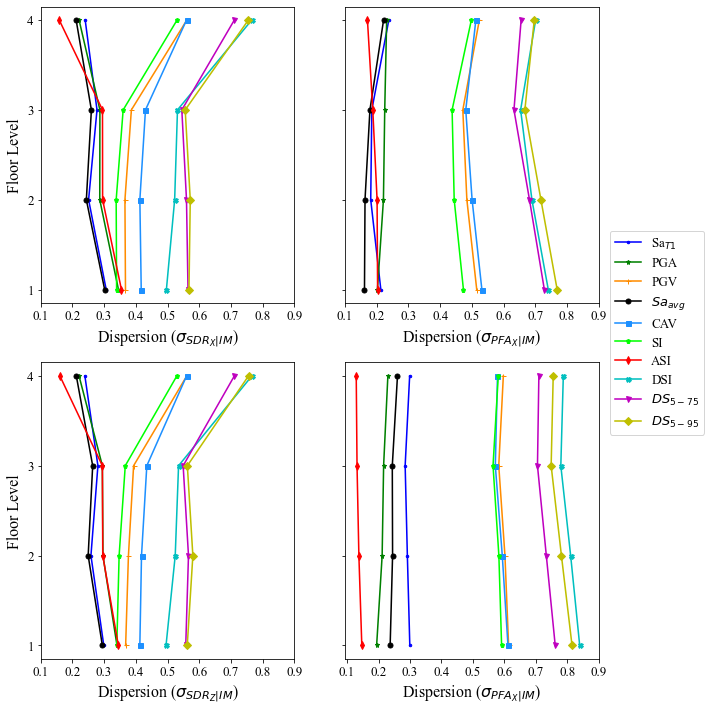

In [94]:
plot_efficiency(9, gminfo_rotD50, IM_list, pairingID = 1, savefig=False, average_EDP=True, Uni_Direction=False)


In [102]:
def portfolio_mean_efficiency(buildingList, df_IMs, IM,
                   pairingID = 1, average_EDP = True, Uni_Direction = False):
    
#     buildingName = ['IM', 'SFD1B', 'SFD3B', 'SFD2B', 'SFD4B', 'MFD1B', 'MFD4B', 'MFD2B', 'MFD5B', 'MFD3B', 'MFD6B']
    buildingName = ['IM', 'SFD1B', 'SFD3B', 'MFD1B', 'MFD4B', 'SFD2B', 'SFD4B', 'MFD2B', 'MFD5B', 'MFD3B', 'MFD6B']
    avg_sdr_eff = pd.DataFrame(data = [], columns=buildingName)
    avg_sdr_eff = avg_sdr_eff.set_index('IM')
    
    avg_pfa_eff = pd.DataFrame(data = [], columns=buildingName)
    avg_pfa_eff = avg_pfa_eff.set_index('IM')
    
    for buildingIndex in range(len(buildingList)):
        numStory = int(BuildingList[buildingIndex].split('_')[0][1])
        floor = np.arange(1, numStory + 1)
        summaryResult = SummaryResutls_efficiency(buildingIndex, df_IMs, IM, pairingID = pairingID,
                                              average_EDP=average_EDP, rotate_EDP=Uni_Direction)
        for i in range(len(IM)):
            if Uni_Direction:
                avg_sdr_eff.loc['%s'%IM[i], buildingName[buildingIndex + 1]] = np.mean(summaryResult.loc['%s'%IM[i]][::2].values)
                avg_pfa_eff.loc['%s'%IM[i], buildingName[buildingIndex + 1]] = np.mean(summaryResult.loc['%s'%IM[i]][1::2].values)
            else:
                avg_sdr_eff.loc['%s'%IM[i], buildingName[buildingIndex + 1]] = np.mean(summaryResult.loc['%s'%IM[i]][::4].values)
                avg_pfa_eff.loc['%s'%IM[i], buildingName[buildingIndex + 1]] = np.mean(summaryResult.loc['%s'%IM[i]][1::4].values)
    return avg_sdr_eff, avg_pfa_eff
        
IM_list = ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI','DS_5to75', 'DS_5to95']      
SDR_mean, PFA_mean= portfolio_mean_efficiency(BuildingList, gminfo_rotD50, IM_list, average_EDP=True, Uni_Direction=True)      

In [103]:
SDR_mean['mean'] = SDR_mean.mean(axis=1)
SDR_mean['meanSFD'] = SDR_mean.loc[:,'SFD1B':'SFD4B'].mean(axis=1)
SDR_mean['meanMFD'] = SDR_mean.loc[:,'MFD1B':'MFD6B'].mean(axis=1)


PFA_mean['mean'] = PFA_mean.mean(axis=1)
PFA_mean['meanSFD'] = PFA_mean.loc[:,'SFD1B':'SFD4B'].mean(axis=1)
PFA_mean['meanMFD'] = PFA_mean.loc[:,'MFD1B':'MFD6B'].mean(axis=1)
SDR_mean.head(n=10)

,SFD1B,SFD3B,MFD1B,MFD4B,SFD2B,SFD4B,MFD2B,MFD5B,MFD3B,MFD6B,mean,meanSFD,meanMFD
IM,,,,,,,,,,,,,
SaT1,0.135326,0.125147,0.261479,0.252945,0.279163,0.290462,0.212831,0.211383,0.257291,0.265971,0.229200,0.224087,0.253941
PGA,0.312127,0.293138,0.319236,0.306663,0.29917,0.304804,0.295727,0.275529,0.295453,0.284636,0.298648,0.305856,0.297652
PGV,0.805139,0.771062,0.74795,0.709083,0.6479,0.554629,0.658052,0.578956,0.498961,0.418932,0.639066,0.705961,0.601808
Sa_avg,0.420839,0.398596,0.413631,0.393187,0.349723,0.341956,0.31395,0.287628,0.242118,0.251355,0.341298,0.386322,0.324194
CAV,0.781625,0.747176,0.729998,0.694635,0.644763,0.553296,0.662832,0.580912,0.552253,0.452346,0.639984,0.691915,0.608879
SI,0.793964,0.758269,0.741218,0.703342,0.637401,0.548806,0.639958,0.563894,0.457743,0.390356,0.623495,0.697166,0.585340
ASI,0.262902,0.251233,0.275765,0.264643,0.252251,0.276995,0.216533,0.212488,0.288152,0.271772,0.257274,0.263965,0.257325
DSI,1.034671,0.992924,0.955782,0.90894,0.843998,0.711623,0.881869,0.774482,0.711375,0.57565,0.839132,0.907990,0.795465
DS_5to75,0.908618,0.873768,0.834168,0.79638,0.752419,0.64849,0.811222,0.723192,0.712044,0.593938,0.765424,0.802307,0.733981


In [17]:
PFA_mean.head(n=10)

,SFD1B,SFD3B,MFD1B,MFD4B,SFD2B,SFD4B,MFD2B,MFD5B,MFD3B,MFD6B,mean,meanSFD,meanMFD
IM,,,,,,,,,,,,,
SaT1,0.105529,0.104081,0.231559,0.227177,0.158261,0.160501,0.143445,0.132199,0.241775,0.252858,0.175739,0.164518,0.193472
PGA,0.290396,0.278041,0.302921,0.301987,0.284974,0.281198,0.252515,0.255698,0.195001,0.198058,0.264079,0.289919,0.259044
PGV,0.749393,0.735972,0.75197,0.747773,0.694295,0.693302,0.638232,0.646597,0.544468,0.559751,0.676175,0.728784,0.659548
Sa_avg,0.387374,0.376901,0.395688,0.392671,0.352607,0.353025,0.300786,0.306361,0.19968,0.209535,0.327463,0.376378,0.313794
CAV,0.71966,0.705951,0.722019,0.71806,0.667226,0.665601,0.61556,0.623166,0.54535,0.555167,0.653776,0.699753,0.639019
SI,0.738824,0.723827,0.743178,0.738568,0.686912,0.68664,0.626069,0.634835,0.520366,0.535949,0.663517,0.719658,0.646564
ASI,0.243362,0.240772,0.241171,0.238817,0.193509,0.193619,0.149957,0.152312,0.142432,0.131743,0.192769,0.225208,0.180445
DSI,0.961422,0.947351,0.958011,0.952384,0.888327,0.887787,0.831161,0.841568,0.750439,0.764062,0.878251,0.932547,0.859217
DS_5to75,0.856658,0.845507,0.85275,0.847879,0.792859,0.789467,0.755034,0.763058,0.696419,0.704479,0.790411,0.830853,0.775243


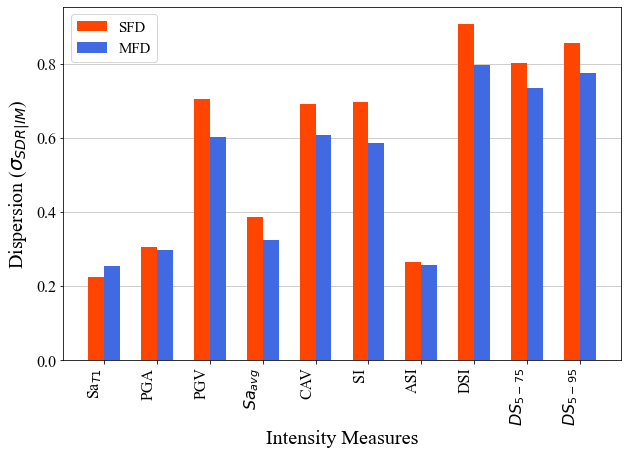

In [98]:
labels = [r'Sa$_{T1}$', 'PGA', 'PGV', r'$Sa_{avg}$', 'CAV', 'SI', 'ASI', 'DSI', r'$DS_{5-75}$',  r'$DS_{5-95}$' ]

meanSFD = SDR_mean['meanSFD'].values
meanMFD = SDR_mean['meanMFD'].values

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(figsize = (10,6.5))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
rects1 = ax.bar(x - width/2, meanSFD, width, label='SFD', color = 'orangered')
rects2 = ax.bar(x + width/2, meanMFD, width, label='MFD', color = 'royalblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'Dispersion ($\sigma_{SDR|IM}$)', fontsize = 20)
ax.set_xlabel('Intensity Measures', fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90, ha = 'right')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.legend(fontsize = 15)
ax.grid(which='both', axis='y',  linewidth=0.6)
ax.set_axisbelow(True)
# os.chdir(r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study/Paper/images')
# plt.savefig('eff_regional_SDR.png', bbox_inches="tight")

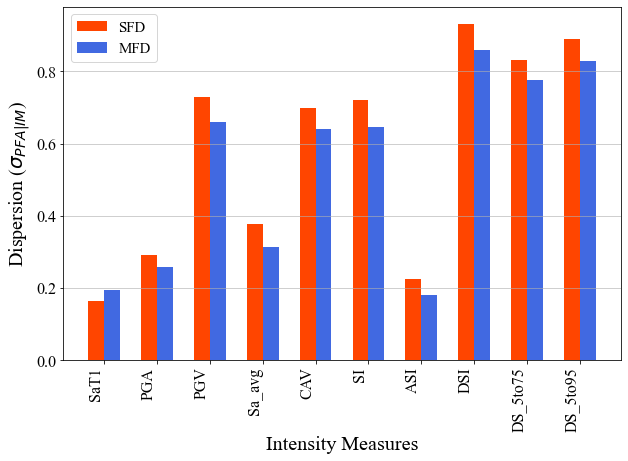

In [26]:
labels = IM_list

meanSFD = PFA_mean['meanSFD'].values
meanMFD = PFA_mean['meanMFD'].values

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(figsize = (10,6.5))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
rects1 = ax.bar(x - width/2, meanSFD, width, label='SFD', color = 'orangered')
rects2 = ax.bar(x + width/2, meanMFD, width, label='MFD', color = 'royalblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'Dispersion ($\sigma_{PFA|IM}$)', fontsize = 20)
ax.set_xlabel('Intensity Measures', fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90, ha = 'right')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.legend(fontsize = 15)
plt.grid(which='both', axis='y',  linewidth=0.6)
# os.chdir(r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study/Paper/images')
# plt.savefig('eff_regional_PFA.png', bbox_inches="tight")